# Production of tagged time series for analysis

The time series will be predicted upon by the trained classifier and then cached for future data viz and analysis.


In [234]:
# Load up the requisite libraries and submodules.
import copy
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import time
import xgboost as xgb

from datetime import datetime
from dynomics import models
from matplotlib.colors import LogNorm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler


# Define file locations.
# DATA_DIR = "../data/multiclass/"
DATA_SAVE_DIR = "../data/20210615_labeled_timeseries/"

In [2]:
# Load up the station IDs. Some of the Accl
station_filenames_list = [
    filename for filename in os.listdir(path=DATA_DIR)
    if (filename[-7:]==".pickle") and ("53155" not in filename)
]

# List of 
stations_id_list = list(
    set(
        fname.split("_")[2].split(".")[0] for fname in station_filenames_list
    )
)

# Load features and targets into features and targets dictionaries, indexed
# by station ID number.
template_dict = {
    station_id : None
    for station_id in stations_id_list
    if station_id != "53155"     # Station 53155's sensor data had data missing for at least one sensor
                               # at literally every time point, so my data preprocessing eliminated it. 
}
features_dict,targets_dict = copy.deepcopy(template_dict), copy.deepcopy(template_dict)
del(template_dict)

for fname in station_filenames_list:
    station_id = fname.split("_")[2].split(".")[0]
    if station_id=='53155':
        continue
    elif "features" in fname:
        features_dict[station_id] = pd.read_pickle(
            DATA_DIR+fname,
        )
    elif "targets" in fname:
        targets_dict[station_id] = pd.read_pickle(
            DATA_DIR+fname,
        )

final_stations_list = [
    station_id for station_id in features_dict.keys()
]

# Got the following station ID info from this URL:
# https://mesonet.agron.iastate.edu/sites/site.php?station=23906&network=USCRN
port_aransas_stat_id = "23906"
feats_df_port_aransas = features_dict[port_aransas_stat_id]
targs_df_port_aransas = targets_dict[port_aransas_stat_id]

# Got the following date-exclusion idea from here:
# https://stackoverflow.com/questions/55680603/pandas-filter-on-datetimeindex-by-excluding-date-range
exclusion_dates = pd.date_range(start="2019-08-01", end="2019-09-01")

features_dict[port_aransas_stat_id] = feats_df_port_aransas.loc[~feats_df_port_aransas.index.isin(exclusion_dates)]

targets_dict[port_aransas_stat_id] = targs_df_port_aransas.loc[~targs_df_port_aransas.index.isin(exclusion_dates)]

# Define ML functions

In [3]:
def check_mkdirs(*paths):
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path)
    return


def fix_conf_mat_labels(conf_mat):
    # Format metal names so as to remove the remnants of tuple-formatting,
    # which is an artifact of the MySQL database and its concentration 
    # specifications.
    new_confusion_matrix_labels = [
        label.split("'")[1] 
        if "'" in label else label
        for label in conf_mat.index.values
    ]
    conf_mat.index = new_confusion_matrix_labels
    conf_mat.columns = new_confusion_matrix_labels
    return conf_mat


def plot_confusion_matrix(
        cm_df,
        title=None,
        cmap=plt.cm.Blues,
        fontsize=12,
        fontcolor=None,
        num_round=4,
        plot_top=0.88,
        cbar_ticks=None,
        cbar_min_divisor=2,
        figsize=None
):
    """
    Create and return a matplotlib figure representing a confusion matrix.

    Input:
        cm_df : pandas.DataFrame
            a pandas dataframe representing a confusion matrix
        title : str
            a plot title
        cmap : color map
            some pyplot colormap to use in plotting
        fontsize : int
            how large the text in each posititon of the matrix should be
        fontcolor : str
            the color that the text in each position of the matrix
    Return: pyplot.figure
        a figure object representing the plot
"""

    # Set figure title.
    if title is None:
        title = 'Confusion matrix'

    # Set figure fontcolor.
    if fontcolor is None:
        fontcolor = "black"
    
    if figsize is None:
        figsize = (14, 10)

    conf_mat = cm_df.values
    conf_mat_nozeros = cm_df.copy()
    #     conf_mat_nozeros['Sum'] = 0
    #     conf_mat_nozeros.loc['Sum'] = 0
    conf_mat_nozeros = conf_mat_nozeros.values

    # Get class names.
    classes = cm_df.index

    # Set color bar ticks and format their labels.
    if cbar_ticks is None:
        cbar_ticks = [0.001, 0.01, 0.1, 0.2, 0.4, 0.8, 1.0]
    cbar_tick_labels = [str(label) for label in cbar_ticks]

    # Set color bar minimum and maximum.
    cbar_min = np.min(
        [i for i in cm_df.values.ravel() if i > 0]) / cbar_min_divisor
    cbar_max = np.max([i for i in cm_df.values.ravel() if i < 1])

    # Eliminate actual zeros from plotting data.
    for i, row in enumerate(conf_mat):
        for j, col in enumerate(row):
            if col < cbar_min:
                conf_mat_nozeros[i, j] = cbar_min

    # Initialize figure and axes objects and plot colored cells.
    fig, ax = plt.subplots(
        1,
        1,
        figsize=figsize
    )
    cax = ax.imshow(
        conf_mat_nozeros,
        interpolation='nearest',
        cmap=cmap,
        norm=LogNorm(vmin=cbar_min, vmax=cbar_max)
    )

    # Add color bar, figure title, labels, and axis ticks.
    cbar = fig.colorbar(cax, ax=ax, ticks=cbar_ticks)
    cbar.ax.set_yticklabels(cbar_tick_labels)
    fig.suptitle(
        title,
        **{'x': 0.53, 'y': 0.97}
    )
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ticks = list(range(len(classes)))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)
    ax.tick_params(axis=u'both', which=u'both', length=0)

    # Add numerical values to the matrix's cells.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(
                j,
                i,
                # conf_mat[i, j],
                '{results:.{digits}f}'.format(
                    results=conf_mat[i, j],
                    digits=num_round
                    ),
                horizontalalignment="center",
                color=fontcolor,
                fontsize=fontsize
            )

    # Format final image for saving.
    plt.tight_layout()
    plt.subplots_adjust(top=plot_top)

    return fig, ax


# def save_kwargs(kwargs_dict, kwargs_dict_name, data_save_dir):
#     with open(data_save_dir+kwargs_dict_name+".txt", "w") as output_file:
#         output_file.write(json.dumps(kwargs_dict))

# Concatenate anomaly data for ML

In [8]:
scaled_feats_dict = {
    stat_id : None
    for stat_id in final_stations_list
    if features_dict[stat_id].shape[1]==15
}
for stat_id in final_stations_list:
    
    df_to_scale = copy.deepcopy(features_dict[stat_id]).drop(columns=["p_official", "t_official"])
    
    if df_to_scale.shape[1]==15:
#         df_to_scale[(df_to_scale == -99999)] = pd.NA
#         df_to_scale = df_to_scale.interpolate(method="time", axis=0)
#         df_to_scale = df_to_scale.fillna(method="bfill", axis=0)
        scaler = StandardScaler(with_mean=True)
        feats_scaled_array = scaler.fit_transform(df_to_scale)
        feats_scaled_df = pd.DataFrame(data=feats_scaled_array, index=df_to_scale.index, columns=df_to_scale.columns)
#         if np.isnan(feats_scaled_array).sum() == 0:
        scaled_feats_dict[stat_id] = copy.deepcopy(feats_scaled_df)
    else:
        continue

final_station_ids_list = [stat_id for stat_id in scaled_feats_dict.keys()]        

features_dfs_list = [scaled_feats_dict[station_id] for station_id in final_station_ids_list]
targets_dfs_list = [targets_dict[station_id] for station_id in final_station_ids_list]

scaled_feats_df = pd.concat(features_dfs_list, axis=0)
targs_df = pd.concat(targets_dfs_list, axis=0)

In [13]:
combined_scaledfeats_targs_df = pd.concat([scaled_feats_df,targs_df], axis=1)

print(combined_scaledfeats_targs_df.shape)

combined_scaledfeats_targs_NONAN_df = combined_scaledfeats_targs_df.dropna(how="any", axis=0)

(627937, 16)


In [14]:
# Re-isolate the targets and then combine them into a 1-D pd.series. 
# Whenever a row has at least one anomaly, then we will collapse that row's 
# values to a single value of 1. Rows with no anomalies shall be labeled as 0.
ml_targs_df = combined_scaledfeats_targs_NONAN_df.iloc[:, 15]

# Re-isolate the ML-ready features.
ml_feats_df = combined_scaledfeats_targs_NONAN_df.iloc[:, :15]

### Calculate the percentage of the ML-ready data that are anomalies

In [18]:
percentage_anomalies = np.round(100 * (ml_targs_df != "").sum()/ml_targs_df.shape[0], 2 )

print(f"{percentage_anomalies}% of the data are anomalies.")

for label in ml_targs_df.unique():
    num_labels = (ml_targs_df == label).sum()
    if label=="":
        label="normal"
    print(label+":", np.round(100*num_labels/ml_targs_df.shape[0],4),"%")

2.32% of the data are anomalies.
normal: 97.6808 %
noise: 1.7951 %
spike: 0.5241 %


# Various ML parameters, plus load the optimized classer

In [47]:
!pwd

/Users/ggraham/repos/innovates/analysis


In [27]:
# Define caching directories.
master_dir = "20210615_generate_tagged_time_series/"
plot_dir = "../plots/" + master_dir
data_save_dir = "../data/" + master_dir
check_mkdirs(plot_dir, data_save_dir)

classer_init_kwargs = {
    "n_jobs":-1,
    "objective":"multi:softmax",
}

fitting_kwargs = {
#     "early_stopping_rounds":50,
    "eval_metric":"merror",
    "verbose":False,
}

param_test_00 = {
    "n_estimators": [int(np.round(n, 0)) for n in np.geomspace(20, 1000, num=6)], 
    "learning_rate":[0.1, 0.4, 0.8],
    'max_depth':range(7, 16,2),
    'min_child_weight':range(5, 13, 2),
    'gamma':[i/10.0 for i in range(0, 6)]
}

features = combined_scaledfeats_targs_NONAN_df.iloc[:,0:15]

targets = combined_scaledfeats_targs_NONAN_df["TAGS"].to_frame()

# ML RANDOMIZED SEARCH WAS PERFORMED AT THIS STEP.
# I erased the dang thing, though, so I wouldn't accidentally re-train the classer.

gridsearch_00 = joblib.load("../data/20210506_XGB_MC_random_search/gridsearch_00.pickle")

print(gridsearch_00.best_params_)

print(gridsearch_00.best_score_)

# Generate confusion matrices using best estimator

In [40]:
# cv = StratifiedShuffleSplit(n_splits=10, random_state=7)
# cv_splits = [split_indices for split_indices in cv.split(features.values, targets.values)]

# feature_frame = features
# target_frame = targets
# classer = gridsearch_00.best_estimator_

# # Create variables to store conf matrix values during cross validation
# unique_labels = target_frame.iloc[:, 0].unique()
# num_labels = len(unique_labels)
# test_mat = np.zeros((num_labels, num_labels))
# train_mat = np.zeros((num_labels, num_labels))
# # perform cross validation
# for split_idx, (train, test) in enumerate(cv_splits[:1]):
#     print("##################################################")
#     print("         ###### Processing "+str(split_idx+1)+" of "+str(len(cv_splits))+" ######")
#     print("            " + time.ctime())
#     print("##################################################")
#     # get train and test splits
#     train_X = feature_frame.values[train]
#     train_y = target_frame.values.ravel()[train]
#     test_X = feature_frame.values[test]
#     test_y = target_frame.values.ravel()[test]

#     # fit training data
#     classer.fit(
#         train_X, train_y, 
#         eval_set=[(test_X, test_y)], 
#         verbose=False,
#     )

#     # Predict for training data and update confusion matrix
#     train_p = classer.predict(train_X)
#     test_p = classer.predict(test_X)


In [41]:
# # Cache these dirs for testing.

# check_mkdirs(data_save_dir+"test/")

# joblib.dump(train_p, data_save_dir+"test/train_p.pickle")
# joblib.dump(test_p, data_save_dir+"test/test_p.pickle")
# joblib.dump(cv_splits, data_save_dir+"test/cv_splits.pickle")

['data/20210615_labeled_timeseries/test/test_p.pickle']

# Stitch predicted points back to their original time series locations

In [42]:
test_p

array(['', '', '', ..., '', '', ''], dtype=object)

In [43]:
# cv_splits splits on combined_scaledfeats_targs_NONAN_df.
# combined_scaledfeats_targs_NONAN_df was created by stitching together
# features_dfs_list = [scaled_feats_dict[station_id] for station_id in final_station_ids_list]
# and then converting it into 
# scaled_feats_df = pd.concat(features_dfs_list, axis=0)
# and then again into 
# combined_scaledfeats_targs_df = pd.concat([scaled_feats_df,targs_df], axis=1).
# Phew. That's a lot of hoops. 

[(array([492972, 302149, 183822, ..., 502872, 552569,  55121]),
  array([443968,  39708,  95277, ...,   3572,  95457, 282265])),
 (array([285804,  88694,  15516, ..., 334268, 404635, 166587]),
  array([289066, 254933, 575210, ...,  60203, 513035,  35766])),
 (array([283116, 477960, 298293, ..., 597419, 148152, 385399]),
  array([477174, 620332, 466580, ..., 485094, 498651,  15531])),
 (array([464725, 331141, 205850, ...,  24605,  55490, 166796]),
  array([598401, 258567, 583063, ..., 386132, 587560, 308606])),
 (array([592595, 372768, 455708, ..., 220128, 163736, 294188]),
  array([602731, 549166,  44363, ...,  88800,  31495, 490300])),
 (array([ 57005, 312065, 207233, ..., 599628, 514811,  50218]),
  array([ 16559, 168525, 210891, ...,  89114, 128799, 310693])),
 (array([446412, 441495, 414131, ...,   7463, 515073, 216067]),
  array([249419, 377915, 353784, ..., 515345, 159413, 120673])),
 (array([142181, 408212, 540835, ..., 474145, 208040, 132648]),
  array([519113, 191134, 170031, 

In [52]:
# total_length = 0
# for station_id in final_station_ids_list:
#     total_length+=scaled_feats_dict[station_id].shape[0]

multiindex_outer = list(station_id for station_id in final_station_ids_list for _ in range(scaled_feats_dict[station_id].shape[0]))

print(len(multiindex_outer))

627937


In [54]:
# Create multiindex arrays.
mi_arrays = [
    np.array(multiindex_outer),
    scaled_feats_df.index.values
]

# Get the original time series data, along with precip and temp.
# This DF's values and columns will be used to create a new multi-index dataframe in the next line.
features_df = pd.concat([features_dict[station_id] for station_id in final_station_ids_list])

# Create a new multiindex dataframe with the station ID #'s. 
mi_features_df = pd.DataFrame(
    data=features_df.values, 
    columns=features_df.columns, 
    index=mi_arrays
)

# Add a column for true labels and another for predicted labels.
mi_features_df["true_labels"] = targs_df.values

# Sanity-check that no additional labels were created.
print(set(mi_features_df.true_labels.values))

In [138]:
mi_features_df.shape

(627937, 18)

# Load predicted labels into CV splits-indexed locations in separate dataframe

In [54]:
# Initialize an empty DF into which I'll load the predicted labels.
# They will have to be loaded in using the CV splits. 
predicted_labels_df = pd.DataFrame(columns=["predicted_labels"], index=mi_features_df.index,)

In [81]:
# Sanity check all the lengths of the CV splits arrays.
print(len(cv_splits[0][0]))

print(len(cv_splits[0][1]))

print(len(test_p))

565143
62794
62794


In [83]:
# Reshape the dang predicted labels.
test_p_reshaped = [[label] for label in test_p]

# Load the reshaped labels into their appropriate indices within the predicted labels.
predicted_labels_df.iloc[cv_splits[0][1]] = test_p_reshaped

In [103]:
# Compare the indices of the loaded predicted labels wiht the original cv_splits indices.
idx_locs = [idx for idx, boolean in enumerate(predicted_labels_df.notna().values.ravel()) if boolean]

cv_splits[0][1].sort()

cv_splits_array = cv_splits[0][1]

print(np.array_equal(idx_locs, cv_splits_array))

True


# Load up the remaining predictions and add them to the master dataset

In [116]:
predictions_dict = {
    split_idx : joblib.load(
        "../data/20210615_labeled_timeseries/test_p"+str(split_idx).zfill(2)+".pickle"
    )
    for split_idx, split in enumerate(cv_splits)
}

In [118]:
# Re-initialize an empty DF into which I'll load the predicted labels.
# They will have to be loaded in using the CV splits. 
predicted_labels_df = pd.DataFrame(columns=["predicted_labels"], index=mi_features_df.index,)

In [136]:
split[1].shape

(62794,)

In [124]:
for split_idx, split in enumerate(cv_splits):
    
    predictions = predictions_dict[split_idx]
    
    # Reshape the dang predicted labels.
    predictions_reshaped = [[label] for label in predictions]

    # Load the reshaped labels into their appropriate indices within the predicted labels.
    predicted_labels_df.iloc[split[1]] = predictions_reshaped

In [148]:
for split_pair in cv_splits:
    split_pair[0].sort()
    split_pair[1].sort()
    
all_splits_list = [
    split[0] for split in cv_splits
]

In [149]:
all_splits_list

[array([     0,      1,      2, ..., 627934, 627935, 627936]),
 array([     0,      1,      2, ..., 627933, 627935, 627936]),
 array([     0,      2,      3, ..., 627934, 627935, 627936]),
 array([     0,      1,      2, ..., 627934, 627935, 627936]),
 array([     0,      1,      2, ..., 627934, 627935, 627936]),
 array([     0,      1,      2, ..., 627934, 627935, 627936]),
 array([     0,      1,      2, ..., 627934, 627935, 627936]),
 array([     0,      2,      3, ..., 627933, 627934, 627936]),
 array([     0,      2,      3, ..., 627934, 627935, 627936]),
 array([     0,      1,      3, ..., 627934, 627935, 627936])]

In [130]:
all_splits_array = np.concatenate(all_splits_list)

In [132]:
all_splits_array.sort()

In [137]:
all_splits_array.shape

(627940,)

In [143]:
predicted_labels_df.isna().values.ravel().sum()

218585

In [152]:
predicted_labels_df_NONA = predicted_labels_df.dropna()

In [155]:
mi_features_df_NONA = mi_features_df.loc[predicted_labels_df_NONA.index]

In [159]:
# mi_all_df = pd.concat([mi_features_df_NONA, predicted_labels_df_NONA], axis=1)

# joblib.dump(mi_all_df, "../data/20210615_labeled_timeseries/multiindexed_features_truepredicted_labels.pickle")

In [167]:
print((mi_all_df.true_labels.values == mi_all_df.predicted_labels.values).sum())

print(mi_all_df.shape[0])

print(
    (mi_all_df.true_labels.values == mi_all_df.predicted_labels.values).sum() / mi_all_df.shape[0]
)

407860
409352
0.9963552150716254


# Explore mi_all_df, which is the multi-indexed pandas.DataFrame containing all raw features, true labels, and predicted labels with the time stamps and station IDs

In [180]:
mi_all_df_copy = mi_all_df.copy()

In [188]:
# mi_all_df_copy.index.set_names("station_id", level=0, inplace=True)
# mi_all_df_copy.index.set_names("time", level=1, inplace=True)
mi_all_df.index.set_names("station_id", level=0, inplace=True)
mi_all_df.index.set_names("time", level=1, inplace=True)

In [206]:
# Convert all temps to float64.
mi_all_df["t_official"] = pd.to_numeric(mi_all_df["t_official"])

In [210]:
# Convert all precip to float64.
mi_all_df["p_official"] = pd.to_numeric(mi_all_df["p_official"])

In [211]:
mi_all_df.loc[mi_all_df.index.get_level_values("station_id")=="53968"]

p_official sw1005 sw1010 sw1020 sw1050 sw1100  \
station_id time                                                                 
53968      2019-12-12 00:00:00         0.0  0.191  0.256  0.309   0.28  0.235   
           2019-12-12 01:00:00         0.0  0.191  0.256  0.309  0.276  0.235   
           2019-12-12 02:00:00         0.0   0.19  0.256   0.31  0.276  0.235   
           2019-12-12 03:00:00         0.0   0.19  0.256   0.31  0.276  0.236   
           2019-12-12 05:00:00         0.0   0.19  0.256  0.309  0.276  0.236   
...                                    ...    ...    ...    ...    ...    ...   
           2020-06-29 08:00:00         0.0  0.144  0.195  0.264  0.305  0.324   
           2020-06-29 13:00:00         0.0  0.144  0.194  0.264  0.305  0.323   
           2020-06-29 14:00:00         0.0  0.144  0.194  0.264  0.305  0.323   
           2020-06-29 15:00:00         0.0  0.143  0.194  0.263  0.304  0.322   
           2020-06-29 19:00:00         0.0  0.141  0.192  0.258  0.303  0.321   

                               sw2005 sw2010 sw2020 sw2050 sw2100 sw3005  \
station_id time                                                            
53968      2019-12-12 00:00:00      0      0      0      0      0      0   
           2019-12-12 01:00:00      0      0      0      0      0      0   
           2019-12-12 02:00:00      0      0      0      0      0      0   
           2019-12-12 03:00:00      0      0      0      0      0      0   
           2019-12-12 05:00:00      0      0      0      0      0      0   
...                               ...    ...    ...    ...    ...    ...   
           2020-06-29 08:00:00  0.113      0      0      0      0  1.344   
           2020-06-29 13:00:00  0.113      0      0      0      0  0.986   
           2020-06-29 14:00:00  0.114      0      0      0      0  1.244   
           2020-06-29 15:00:00  0.114      0      0      0      0  1.638   
           2020-06-29 19:00:00  0.112      0      0      0      0  4.011   

                               sw3010 sw3020 sw3050 sw3100  t_official  \
station_id time                                                          
53968      2019-12-12 00:00:00      0  0.128      0      0       7.179   
           2019-12-12 01:00:00      0  0.127      0      0       5.196   
           2019-12-12 02:00:00      0  0.126      0      0       5.748   
           2019-12-12 03:00:00      0  0.126      0      0       5.666   
           2019-12-12 05:00:00      0  0.126      0      0       4.948   
...                               ...    ...    ...    ...         ...   
           2020-06-29 08:00:00  1.286  0.205      0  0.351      26.326   
           2020-06-29 13:00:00  0.827  0.205      0  0.351      27.092   
           2020-06-29 14:00:00  0.936  0.204      0  0.351      28.087   
           2020-06-29 15:00:00  1.127  0.205      0   0.35      28.904   
           2020-06-29 19:00:00  2.719  0.204      0  0.349      31.370   

                               true_labels predicted_labels  
station_id time                                              
53968      2019-12-12 00:00:00                               
           2019-12-12 01:00:00                               
           2019-12-12 02:00:00                               
           2019-12-12 03:00:00                               
           2019-12-12 05:00:00                               
...                                    ...              ...  
           2020-06-29 08:00:00                               
           2020-06-29 13:00:00                               
           2020-06-29 14:00:00                               
           2020-06-29 15:00:00                               
           2020-06-29 19:00:00                               

[3138 rows x 19 columns]

In [212]:
station_df = mi_all_df.loc[mi_all_df.index.get_level_values("station_id")=="53968"]

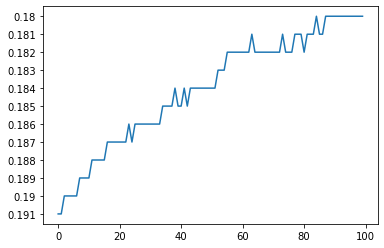

In [221]:
# Plot the temps to make sure they look sane.
# plt.plot(station_df["t_official"].values)
# sns.lineplot(x="time", y="t_official", data=station_df)
plt.plot(station_df["sw1005"].values[:100])

In [201]:
station_df["t_official"].values

array(['7.179', '5.196', '5.748', ..., '28.087', '28.904', '31.37'],
      dtype=object)

# Output these values in CSV form for Ronnie

In [235]:
csv_save_dir = DATA_SAVE_DIR+"csv_station/"
check_mkdirs(csv_save_dir)

In [236]:
station_df.to_csv(csv_save_dir+"save_test.csv")

In [237]:
for station_id in final_station_ids_list:
    station_df = mi_all_df.loc[mi_all_df.index.get_level_values("station_id")==station_id]
    station_df.to_csv(csv_save_dir+"station_"+station_id+"_data_labels.csv")

# Go back over and inspect results

In [240]:
models.confusion_matrix(mi_all_df.true_labels.values, mi_all_df.predicted_labels.values, labels = ["", "noise", "spike"])

array([[399168,    536,    134],
       [   570,   6785,      2],
       [   246,      4,   1907]])

In [243]:
(mi_all_df.true_labels == "spike").sum()

2157

In [241]:
plot_confusion_matrix(confusion_score)

Signature:
plot_confusion_matrix(
    cm_df,
    title=None,
    cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x1180aca60>,
    fontsize=12,
    fontcolor=None,
    num_round=4,
    plot_top=0.88,
    cbar_ticks=None,
    cbar_min_divisor=2,
    figsize=None,
)
Docstring:
Create and return a matplotlib figure representing a confusion matrix.

Input:
    cm_df : pandas.DataFrame
        a pandas dataframe representing a confusion matrix
    title : str
        a plot title
    cmap : color map
        some pyplot colormap to use in plotting
    fontsize : int
        how large the text in each posititon of the matrix should be
    fontcolor : str
        the color that the text in each position of the matrix
Return: pyplot.figure
    a figure object representing the plot
File:      ~/repos/innovates/analysis/<ipython-input-3-53e6e71ceed0>
Type:      function


In [ ]:


`

a






a



















